# Detecting Sentiment and Potential Bias in Amazon Reviews

## Introduction

Our team recognizes that online product reviews are a rich source of public sentiment. However, the subjective nature of reviews can introduce bias. This project for our NLP class tries to investigate sentiment classification using NLP, with an interest in identifying patterns that may suggest some bias.

We are using the Amazon Fine Food Reviews dataset to explore 2 different approaches!
- TF-IDF + Logistic Regression baseline
- A transformer-based model (BERT)

Our goals are to implement models for sentiment detections and to analyze any potential misclassifications. Also, we want to examine indicators of potential review bias.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [6]:
df = pd.read_csv('./Reviews.csv')
print(df.shape)
df = df.head(500) #reducing to 500 rows for faster processing
print(df.shape)

(568454, 10)
(500, 10)


In [7]:
df.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


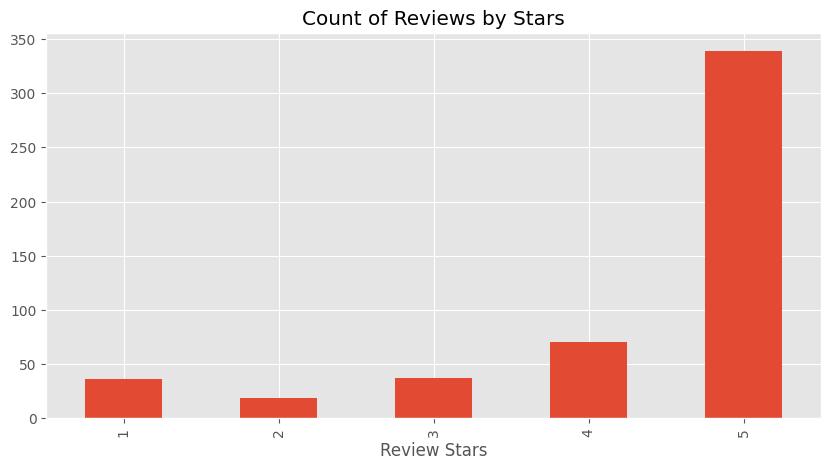

In [8]:
ax = df['Score'].value_counts().sort_index().plot(kind = "bar", 
                                             title = "Count of Reviews by Stars", 
                                             figsize=(10, 5))
ax.set_xlabel("Review Stars")
plt.show()

In [9]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [11]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [12]:
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
sia .polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:  72%|#######1  | 358M/499M [00:00<?, ?B/s]

C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\farza\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [14]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [15]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [16]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_results.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_results}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id83
Broke for id187


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(df, how = 'left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [19]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

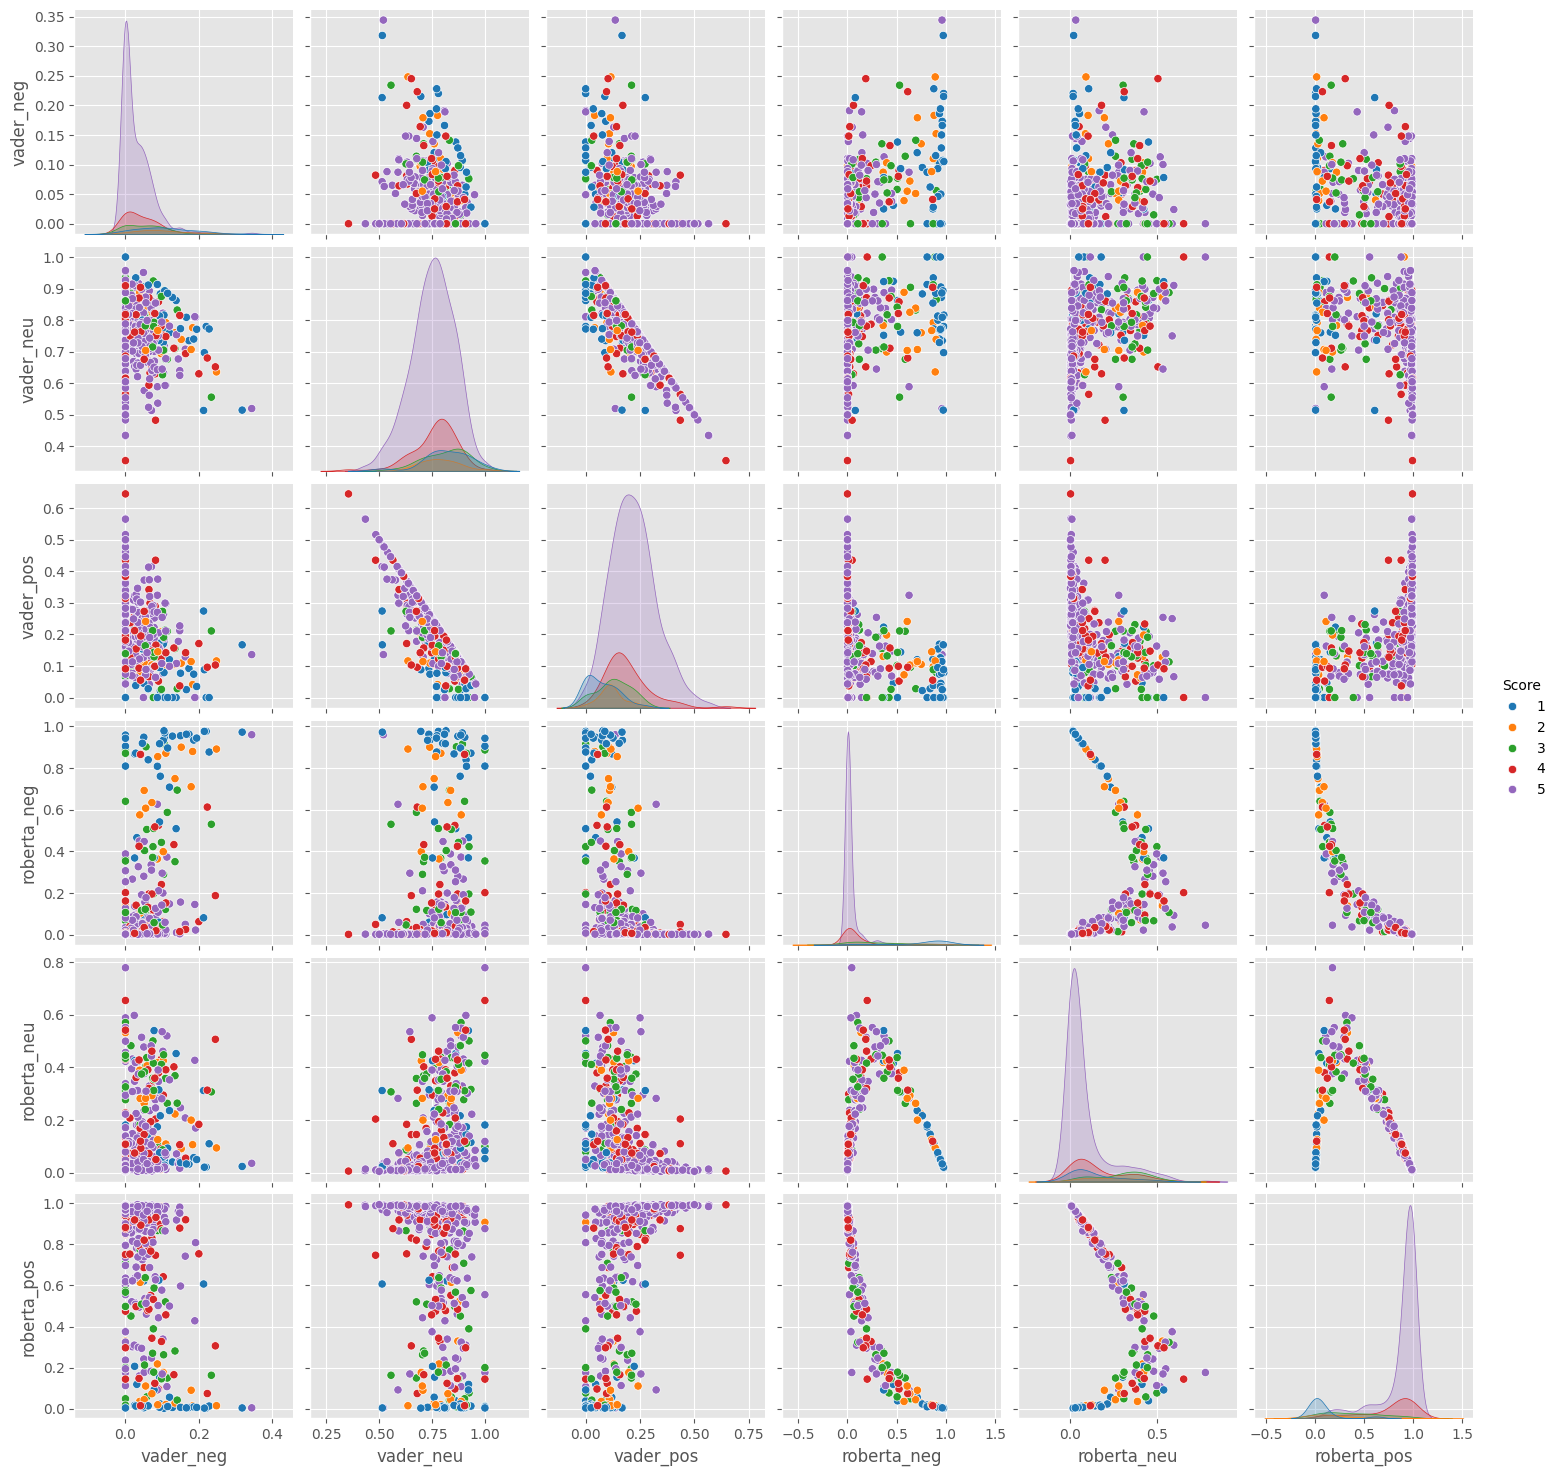

In [20]:
sns.pairplot(data=results_df, 
             vars= ['vader_neg', 'vader_neu', 'vader_pos',
              'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Score',
            palette = 'tab10')
plt.show()

In [21]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [22]:
results_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [23]:
# negative sentiment 5-Star view

In [24]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [25]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [26]:
from transformers import pipeline
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\farza\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' 

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [27]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [28]:
######################################################################################3

In [30]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding = 'latin-1', header = None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
# to reduce to 500 rows for faster processing
df = df.head(500) 
print(df.shape)

(500, 6)


In [31]:
df.head()


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
#first 10 tweets
for i, tweet in enumerate(df['text'].head(10)):
    print(f"{i+1}: {tweet}")

1: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
2: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
3: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
4: my whole body feels itchy and like its on fire 
5: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
6: @Kwesidei not the whole crew 
7: Need a hug 
8: @LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
9: @Tatiana_K nope they didn't have it 
10: @twittera que me muera ? 


In [34]:
analyze = SentimentIntensityAnalyzer()

In [35]:
#testing the vader sentiment analysis
print(analyze.polarity_scores('I am so happy'))
print(analyze.polarity_scores('I am so sad'))

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}


In [36]:
def polarity_scores_vader(text):
    scores = analyze.polarity_scores(text)
    scores_dict = {
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound' : scores['compound']
    }
    return scores_dict

In [37]:
#running vader polarity scores on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try: 
        text = row['text']
        myid = row['id']
    #     direct way of doing it: res[myid] = analyze.polarity_scores(text)
        vader_results = polarity_scores_vader(text)
        res[myid] = vader_results
    except RunTimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [38]:
#creating a dataframe from the res dictionary
vaders_df = pd.DataFrame(res).T
vaders_df = vaders_df.reset_index().rename(columns={'index':'id'})
vaders_df = vaders_df.merge(df, how = 'left')

In [39]:
print(vaders_df.head())

           id  vader_neg  vader_neu  vader_pos  vader_compound  target  \
0  1467810369      0.129      0.745      0.126         -0.0173       0   
1  1467810672      0.303      0.697      0.000         -0.7500       0   
2  1467810917      0.000      0.833      0.167          0.4939       0   
3  1467811184      0.321      0.500      0.179         -0.2500       0   
4  1467811193      0.241      0.759      0.000         -0.6597       0   

                           date      flag             user  \
0  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I di

In [40]:
#to get the vader_sentiment column
vaders_df['vader_sentiment'] = vaders_df['vader_compound'].apply(lambda c: 'pos' if c >= 0 else 'neg')

In [41]:
print(vaders_df.columns)
print(vaders_df[['id', 'vader_compound', 'vader_sentiment']].head())
print(vaders_df['vader_compound'].isnull().sum())

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'target',
       'date', 'flag', 'user', 'text', 'vader_sentiment'],
      dtype='object')
           id  vader_compound vader_sentiment
0  1467810369         -0.0173             neg
1  1467810672         -0.7500             neg
2  1467810917          0.4939             pos
3  1467811184         -0.2500             neg
4  1467811193         -0.6597             neg
0


C:\Users\farza\AppData\Local\Temp\ipykernel_32588\141843628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=vaders_df, palette='viridis')


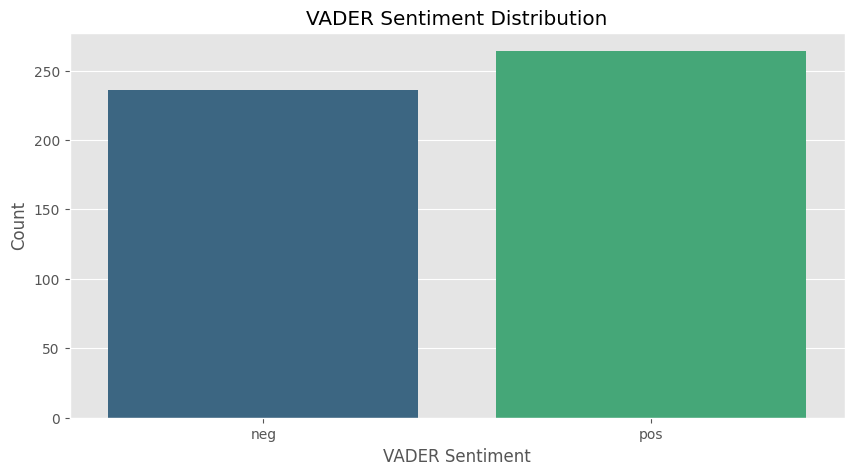

In [42]:
#visualization of the sentiments using vader
plt.figure(figsize=(10, 5))
sns.countplot(x='vader_sentiment', data=vaders_df, palette='viridis')
plt.title('VADER Sentiment Distribution')
plt.xlabel('VADER Sentiment')
plt.ylabel('Count')
plt.show()

In [43]:
#roberta analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [44]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [45]:
#running the roberta model 
def polarity_scores_roberta(text):
    # make the text to tokens
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text) #**encoded_text unpacks the dictionary
    scores = output[0][0].detach().numpy()
    #softmax converts logits into probabilities that sum to 1
    #providing the models confidence in each class (pos.neg,neu)
    scores = softmax(scores) 
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [46]:
#running it on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['text']
        myid = row['id']
        vader_results = analyze.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_results.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)
#         result[myid] = roberta_results
        both = {**vader_result_rename, **roberta_results}
        result[myid] = both
    except RunTimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [47]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns = {'index' : 'id'})
results_df = results_df.merge(df, how = 'left')

In [48]:
print(results_df.head())

           id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0  1467810369      0.129      0.745      0.126         -0.0173     0.773734   
1  1467810672      0.303      0.697      0.000         -0.7500     0.932836   
2  1467810917      0.000      0.833      0.167          0.4939     0.146453   
3  1467811184      0.321      0.500      0.179         -0.2500     0.813473   
4  1467811193      0.241      0.759      0.000         -0.6597     0.945602   

   roberta_neu  roberta_pos  target                          date      flag  \
0     0.197484     0.028783       0  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1     0.061818     0.005346       0  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2     0.702749     0.150798       0  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3     0.163006     0.023521       0  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4     0.050249     0.004149       0  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                

In [49]:
#create a new column for roberta sentiment based on the highest score
results_df['roberta_sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1)
results_df['roberta_sentiment'] = results_df['roberta_sentiment'].map({
    'roberta_neg': 'negative',
    'roberta_neu': 'neutral',
    'roberta_pos': 'positive'
})

In [50]:
#showing vader sentiment in the new dictionary
results_df['vader_sentiment'] = results_df['vader_compound'].apply(lambda c: 'pos' if c >= 0 else 'neg')

C:\Users\farza\AppData\Local\Temp\ipykernel_32588\1213993125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'roberta_sentiment', data=results_df, palette = 'viridis')


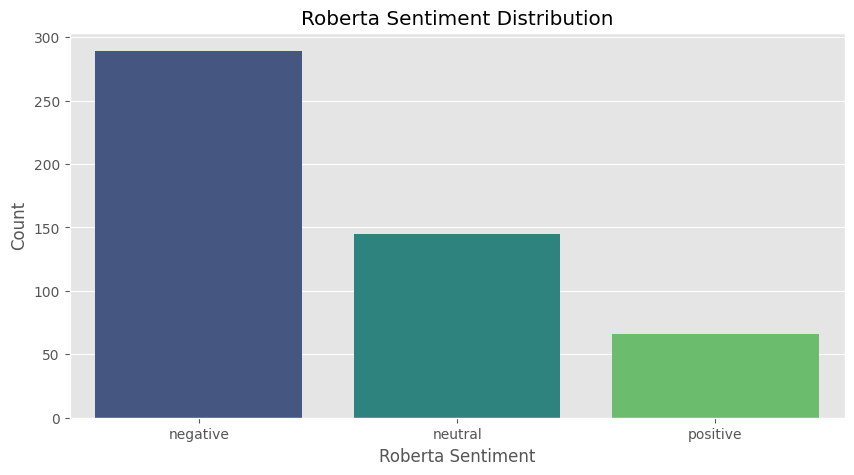

In [51]:
#visualizing the roberta sentiment distribution 
plt.figure(figsize = (10,5))
sns.countplot(x = 'roberta_sentiment', data=results_df, palette = 'viridis')
plt.title('Roberta Sentiment Distribution')
plt.xlabel('Roberta Sentiment')
plt.ylabel('Count')
plt.show()

C:\Users\farza\AppData\Local\Temp\ipykernel_32588\607411220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='vader_sentiment', data=results_df, palette='viridis')
C:\Users\farza\AppData\Local\Temp\ipykernel_32588\607411220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='roberta_sentiment', data=results_df, palette='viridis')


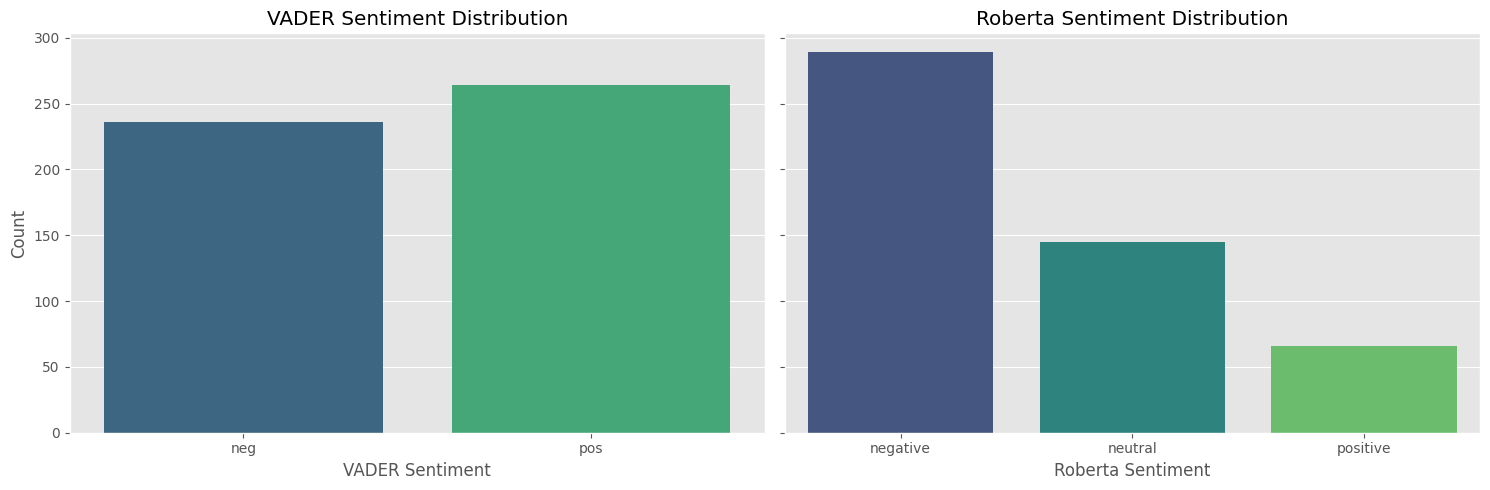

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(ax=axes[0], x='vader_sentiment', data=results_df, palette='viridis')
axes[0].set_title('VADER Sentiment Distribution')
axes[0].set_xlabel('VADER Sentiment')
axes[0].set_ylabel('Count')
sns.countplot(ax=axes[1], x='roberta_sentiment', data=results_df, palette='viridis')
axes[1].set_title('Roberta Sentiment Distribution')
axes[1].set_xlabel('Roberta Sentiment')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

## Text Preprocessing

For our next step, we will try to clean and prepare the review texts for model training. 

Precisely, we will remove punctuation and stop word, tokenize, and label encode the sentiment classes as part of pre-processing.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

def preprocess(text):
    tokens = text.lower().split()
    tokens = [word.strip(string.punctuation) for word in tokens if word.lower() not in stopwords.words('english')]
    return " ".join(tokens)

df['processed_text'] = df['Text'].astype(str).apply(preprocess)
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)  # Binary sentiment

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)


As part of our baseline model, we will build a simple text classifier using TF-IDF features and a Logistic Regression model. 

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

print(classification_report(y_test, y_pred_lr))


Due to computational constraints, our team decided not to include full fine-tuning here. However, BERT-based models like maybe bert-base-uncased or BERTweet can be applied for higher accuracy and deeper analysis.

Our team encourages trying to approach with cloud-based or GPU-accelerated notebooks.